In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Linnaeus_Bicubic_32_spliit.zip

Streaming output truncated to the last 5000 lines.
  inflating: Linnaeus_Bicubic_32_split/train/bird/1058_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1059_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/105_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1060_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1061_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1062_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1064_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1065_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1066_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1067_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1068_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1070_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1071_128.png  
  inflating: Linnaeus_Bicubic_32_split/train/bird/1072_128.png  
  inflating: Linnaeus_Bicubic_32_split/t

In [3]:
import numpy as np
import pandas as pd
from pandas import Series

import pathlib
from glob import glob
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.python.keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, BackupAndRestore
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import regularizers

In [4]:
src_path_train = "/content/Linnaeus_Bicubic_32_split/train"
src_path_val = "/content/Linnaeus_Bicubic_32_split/val"
src_path_test = "/content/Linnaeus_Bicubic_32_split/test"

In [74]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(rescale=1./255,
                                     )

val_generator = ImageDataGenerator(rescale=1./255,
                                   )

test_generator = ImageDataGenerator(rescale=1./255)

In [75]:
#Fit the augmentation method to the data
train_generatorr = train_generator.flow_from_directory(src_path_train,
                            
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    target_size=(32,32),
                                                    shuffle=True,
                                                    seed=42)

validation_generator = train_generator.flow_from_directory(src_path_val,
                                                        target_size=(32,32),
                                                        batch_size=32,
                                                        color_mode="rgb",
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42)
test_generatorr = test_generator.flow_from_directory(
    src_path_test,
    target_size=(32,32),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 4800 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [83]:
mobile = tf.keras.applications.mobilenet.MobileNet(
    include_top = False,
    weights="imagenet",
    input_tensor=None,
    pooling="max",
    classes=5,
    classifier_activation="softmax")
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                         

In [147]:
from keras import Sequential

for layer in mobile.layers:
  layer.trainable = False

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(mobile)
model_2.add(Flatten())

#Add the Dense layers along with activation and batch normalization
#model_2.add(Dense(4096,activation=('relu')))
#model_2.add(Dropout(.1, seed=42))
model_2.add(Dense(32,activation=('relu')))
model_2.add(Dropout(.5, seed=42))
model_2.add(Dense(32,activation=('relu')))
model_2.add(Dropout(.5, seed=42))
#model_2.add(Dense(2048,activation=('relu')))
#model_2.add(Dropout(.2, seed=42))
#model_2.add(Dense(2048,activation=('relu'))) 
#model_2.add(Dropout(.2, seed=42))
# model_2.add(Dense(2048,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01))) 
# model_2.add(Dropout(.3, seed=42))#Adding a dropout layer that will randomly drop 50% of the weights
# model_2.add(Dense(1024,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01)))
# model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(5,activation=('softmax'))) #This is the classification layer

model_2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 1024)              0         
                                                                 
 dense_68 (Dense)            (None, 32)                32800     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 32)                1056      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                     

In [148]:
from keras.optimizers import SGD,Adam
# from tensorflow.keras.optimizers.legacy import SGD
learning_rate=.00001

sgd = tf.keras.optimizers.legacy.SGD(lr=learning_rate,momentum=.9,nesterov=False)
adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [149]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.1, min_lr=0.00001,min_delta=0.001)
# early_stopping_monitor = EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)

In [150]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [151]:
history = model_2.fit_generator(
              train_generatorr,
              steps_per_epoch = train_generatorr.samples // 32,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // 32,
              callbacks = [learning_rate_reduction],
              epochs = 35)

Epoch 1/35


<ipython-input-151-6b46135707a0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(


150/150 [==============================] - 6s 27ms/step - loss: 3.0607 - accuracy: 0.1594 - val_loss: 1.9536 - val_accuracy: 0.1858 - lr: 1.0000e-05
Epoch 2/35
150/150 [==============================] - 3s 20ms/step - loss: 2.6431 - accuracy: 0.1865 - val_loss: 1.7545 - val_accuracy: 0.2407 - lr: 1.0000e-05
Epoch 3/35
150/150 [==============================] - 3s 21ms/step - loss: 2.2881 - accuracy: 0.2313 - val_loss: 1.5924 - val_accuracy: 0.3269 - lr: 1.0000e-05
Epoch 4/35
150/150 [==============================] - 3s 21ms/step - loss: 2.0018 - accuracy: 0.2790 - val_loss: 1.4830 - val_accuracy: 0.3927 - lr: 1.0000e-05
Epoch 5/35
150/150 [==============================] - 3s 20ms/step - loss: 1.8082 - accuracy: 0.3142 - val_loss: 1.4020 - val_accuracy: 0.4426 - lr: 1.0000e-05
Epoch 6/35
150/150 [==============================] - 5s 32ms/step - loss: 1.6517 - accuracy: 0.3471 - val_loss: 1.3355 - val_accuracy: 0.4806 - lr: 1.0000e-05
Epoch 7/35
150/150 [==============================]

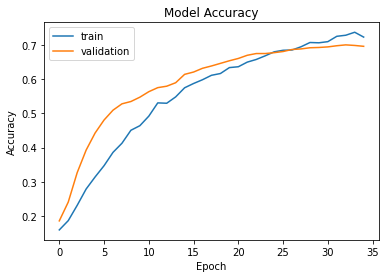

In [152]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

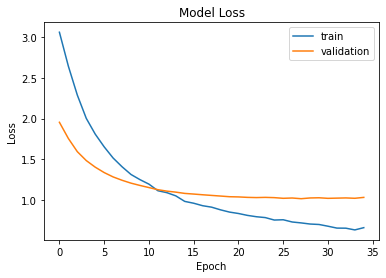

In [153]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [154]:
evaluate = model_2.evaluate(test_generatorr)
print(evaluate)

2000/2000 [==============================] - 13s 6ms/step - loss: 1.0154 - accuracy: 0.6985
[1.0154352188110352, 0.6984999775886536]


In [156]:
model_2.save("BICUBIC_Linnaeus_MobileNet_6984.h5")